# 2D Geometry File Parsing

This notebook demonstrates parsing and manipulating 2D geometry elements from HEC-RAS plain text geometry files, including:
- Storage Area operations (BaldEagleCrkMulti2D)
- SA/2D Connection operations and dam crest profiles (BaldEagleCrkMulti2D)
- Gate extraction (Davis project)
- Practical dam breach workflow using both projects


## Overview

This notebook demonstrates extraction of **2D geometry elements** from HEC-RAS geometry files. 2D areas use computational meshes rather than cross sections.

### What You'll Learn
- Extract storage areas and elevation-volume curves
- List SA/2D connections and dam crest profiles
- Pull gate configurations from a project that includes gates (Davis)
- Use multiple RasPrj objects to target specific projects

### LLM Forward Approach
- **Verification**: Compare storage curves and connection profiles with HEC-RAS GUI
- **Visual Outputs**: Plot storage curves and crest profiles for quick review
- **Audit Trail**: Keep geometry file paths and ras_object context explicit

### Reference Documentation
- [HEC-RAS 2D Modeling User's Manual](https://www.hec.usace.army.mil/software/hec-ras/documentation.aspx)
- [HEC-RAS User's Manual, Chapter 6](https://www.hec.usace.army.mil/software/hec-ras/documentation.aspx)


In [14]:
# =============================================================================
# DEVELOPMENT MODE TOGGLE
# =============================================================================
from pathlib import Path
import sys

USE_LOCAL_SOURCE = True  # <-- TOGGLE THIS

if USE_LOCAL_SOURCE:
    local_path = str(Path.cwd().parent)
    if local_path not in sys.path:
        sys.path.insert(0, local_path)
    print(f"LOCAL SOURCE MODE: Loading from {local_path}/ras_commander")
else:
    print("PIP PACKAGE MODE: Loading installed ras-commander")

# Import RAS Commander geometry modules
from ras_commander import (
    RasGeometry, GeomLateral,
    RasGeometryUtils,
    HdfHydraulicTables,
    RasExamples,
    init_ras_project,
    RasCmdr,
    RasPrj
)

# Additional imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

# Verify which version loaded
import ras_commander
print(f"Loaded: {ras_commander.__file__}")
print(f"Working directory: {Path.cwd()}")


LOCAL SOURCE MODE: Loading from c:\GH\ras-commander/ras_commander
Loaded: c:\GH\ras-commander\ras_commander\__init__.py
Working directory: c:\GH\ras-commander\examples


## Parameters

Configure these values to customize the notebook for your project.

In [15]:
# =============================================================================
# PARAMETERS - Edit these to customize the notebook
# =============================================================================
from pathlib import Path

# Project Configuration
PROJECT_NAME_2D = "BaldEagleCrkMulti2D"  # 2D geometry source project
PROJECT_NAME_GATES = "Davis"             # Gate information source project
PROJECT_SUFFIX = "202"                   # Folder suffix for extracted projects
RAS_VERSION = "6.6"                      # HEC-RAS version (6.3, 6.5, 6.6, etc.)

# Geometry Settings
GEOM_NUMBER_2D = "12"      # Geometry file with SA/2D connections (BaldEagle)
GATE_GEOM_NUMBER = None    # Optional: set if you know the Davis geometry with gates
RIVER = None               # Not applicable for 2D geometry
REACH = None               # Not applicable for 2D geometry
CROSS_SECTION = None       # Not applicable for 2D geometry


## Package Setup and Imports

In [16]:
# Extract and initialize the example projects
project_paths = RasExamples.extract_project(
    [PROJECT_NAME_2D, PROJECT_NAME_GATES],
    suffix=PROJECT_SUFFIX
)

bald_eagle_path = project_paths[0]
davis_path = project_paths[1]

# Initialize each project with its own RasPrj instance
bald_eagle_ras = RasPrj()
init_ras_project(bald_eagle_path, RAS_VERSION, ras_object=bald_eagle_ras)

print(f"Bald Eagle project initialized: {bald_eagle_ras.project_name}")
print(f"Found {len(bald_eagle_ras.geom_df)} geometry files")
print(f"Found {len(bald_eagle_ras.plan_df)} plan files")


# Initialize Davis for gate information
# (use a separate RasPrj to keep project state isolated)
davis_ras = RasPrj()
init_ras_project(davis_path, RAS_VERSION, ras_object=davis_ras)

print("")
print(f"Davis project initialized: {davis_ras.project_name}")
print(f"Found {len(davis_ras.geom_df)} geometry files")
print(f"Found {len(davis_ras.plan_df)} plan files")


def find_gate_connections(ras_object, geom_number=None):
    # Find a geometry file and connection table that includes gate definitions.
    if geom_number:
        geom_row = ras_object.geom_df.loc[
            ras_object.geom_df['geom_number'] == geom_number
        ]
        if geom_row.empty:
            raise ValueError(
                f"Geometry number {geom_number} not found in {ras_object.project_name}"
            )
        geom_file = Path(geom_row.iloc[0]["full_path"])
        connections = RasGeometry.get_connections(geom_file)
        if connections.empty or "Num_Gates" not in connections.columns:
            return geom_file, connections, pd.DataFrame()
        gate_connections = connections[connections['Num_Gates'] > 0]
        return geom_file, connections, gate_connections

    for _, row in ras_object.geom_df.iterrows():
        geom_file = Path(row["full_path"])
        connections = RasGeometry.get_connections(geom_file)
        if connections.empty or "Num_Gates" not in connections.columns:
            continue
        gate_connections = connections[connections['Num_Gates'] > 0]
        if len(gate_connections) > 0:
            return geom_file, connections, gate_connections

    return None, pd.DataFrame(), pd.DataFrame()


davis_gate_geom_file, davis_connections, davis_gate_connections = (
    find_gate_connections(davis_ras, GATE_GEOM_NUMBER)
)

if davis_gate_geom_file is not None:
    print("")
    print(f"Gate geometry identified: {davis_gate_geom_file.name}")
    print(f"Gate connections found: {len(davis_gate_connections)}")
else:
    print("")
    print("No gate connections found in Davis project")


2026-01-12 12:51:08 - ras_commander.RasExamples - INFO - ----- RasExamples Extracting Project -----
2026-01-12 12:51:08 - ras_commander.RasExamples - INFO - Extracting project 'BaldEagleCrkMulti2D' as 'BaldEagleCrkMulti2D_202'
2026-01-12 12:51:08 - ras_commander.RasExamples - INFO - Folder 'BaldEagleCrkMulti2D_202' already exists. Deleting existing folder...
2026-01-12 12:51:08 - ras_commander.RasExamples - INFO - Existing folder 'BaldEagleCrkMulti2D_202' has been deleted.
2026-01-12 12:51:10 - ras_commander.RasExamples - INFO - Successfully extracted project 'BaldEagleCrkMulti2D' to C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_202
2026-01-12 12:51:10 - ras_commander.RasExamples - INFO - ----- RasExamples Extracting Project -----
2026-01-12 12:51:10 - ras_commander.RasExamples - INFO - Extracting project 'Davis' as 'Davis_202'
2026-01-12 12:51:10 - ras_commander.RasExamples - INFO - Folder 'Davis_202' already exists. Deleting existing folder...
2026-01-12 12:51:10 

Bald Eagle project initialized: BaldEagleDamBrk
Found 10 geometry files
Found 11 plan files

Davis project initialized: DavisStormSystem
Found 1 geometry files
Found 1 plan files

No gate connections found in Davis project


DEV NOTE: No gate connections found in Davis project   -   This needs to be mapped to a different example project that has gate operations. 

## Section 1: Storage Area Operations

Storage areas represent reservoirs, detention basins, or other water storage features in the HEC-RAS model. We'll demonstrate extracting storage area properties and elevation-volume curves.

### 1.1 List Storage Areas

#### Select Geometry 12 (SA to 2D Connection)

Geometry 12 in the BaldEagleCrkMulti2D project contains storage areas and SA/2D connections for dam breach analysis.


In [17]:
# Select geometry 12 which has SA/2D connections for dam breach analysis
bald_eagle_geom_number = GEOM_NUMBER_2D
geom_row = bald_eagle_ras.geom_df.loc[
    bald_eagle_ras.geom_df['geom_number'] == bald_eagle_geom_number
]

if geom_row.empty:
    raise ValueError(
        f"Geometry number {bald_eagle_geom_number} not found in "
        f"{bald_eagle_ras.project_name}"
    )

bald_eagle_geom_file = Path(geom_row.iloc[0]["full_path"])
bald_eagle_geom_hdf = Path(geom_row.iloc[0]["hdf_path"])

print(f"Selected geometry (Bald Eagle): {bald_eagle_geom_file.name}")
print(
    "Geometry HDF: "
    f"{bald_eagle_geom_hdf.name if bald_eagle_geom_hdf.exists() else 'Not yet created'}"
)


Selected geometry (Bald Eagle): BaldEagleDamBrk.g12
Geometry HDF: BaldEagleDamBrk.g12.hdf


print("Bald Eagle geometry entries:")
display.display(bald_eagle_ras.geom_df)

print("")
print("Davis geometry entries:")
display.display(davis_ras.geom_df)


In [18]:
# Path to dam breach geometry with storage areas (Bald Eagle)
dam_geom_file = bald_eagle_geom_file

print(f"Geometry file: {dam_geom_file.name}")

# Get storage areas (excluding 2D flow areas)
storage_areas = RasGeometry.get_storage_areas(dam_geom_file, exclude_2d=True)

print("")
print(f"Traditional storage areas found: {len(storage_areas)}")
for i, name in enumerate(storage_areas, 1):
    print(f"  {i}. {name}")

# Get all storage areas (including 2D)
all_storage = RasGeometry.get_storage_areas(dam_geom_file, exclude_2d=False)

print("")
print(f"All storage areas (including 2D): {len(all_storage)}")
for i, name in enumerate(all_storage, 1):
    print(f"  {i}. {name}")


2026-01-12 12:51:11 - ras_commander.geom.GeomStorage - INFO - Found 1 storage areas in BaldEagleDamBrk.g12
2026-01-12 12:51:11 - ras_commander.geom.GeomStorage - INFO - Found 2 storage areas in BaldEagleDamBrk.g12


Geometry file: BaldEagleDamBrk.g12

Traditional storage areas found: 1
  1. Reservoir Pool

All storage areas (including 2D): 2
  1. BaldEagleCr
  2. Reservoir Pool


### 1.2 Extract Elevation-Volume Curve

In [19]:
# Get elevation-volume curve for first storage area
if len(storage_areas) > 0:
    area_name = storage_areas[0]
    print(f"Extracting elevation-volume curve for: {area_name}")
    
    try:
        elev_vol = RasGeometry.get_storage_elevation_volume(dam_geom_file, area_name)

        print(f"\nStorage Curve Data:")
        print(f"  Points: {len(elev_vol)}")
        print(f"  Elevation range: {elev_vol['Elevation'].min():.2f} to {elev_vol['Elevation'].max():.2f} ft")
        print(f"  Volume range: {elev_vol['Volume'].min():.0f} to {elev_vol['Volume'].max():.0f} cu ft")

        print("\nFirst 10 points:")
        display.display(elev_vol.head(10))
    except ValueError as e:
        print(f"\nNote: Could not extract elevation-volume curve: {e}")
        print("This may be a 2D flow area without traditional storage curve data.")
        print("Trying second storage area if available...")
        
        if len(storage_areas) > 1:
            area_name = storage_areas[1]
            print(f"\nTrying: {area_name}")
            try:
                elev_vol = RasGeometry.get_storage_elevation_volume(dam_geom_file, area_name)
                print(f"Storage Curve Data:")
                print(f"  Points: {len(elev_vol)}")
                display.display(elev_vol.head(10))
            except ValueError as e2:
                print(f"Could not extract from {area_name} either: {e2}")
                elev_vol = pd.DataFrame({'Elevation': [], 'Volume': []})
        else:
            elev_vol = pd.DataFrame({'Elevation': [], 'Volume': []})
else:
    print("No traditional storage areas found in this geometry file")
    elev_vol = pd.DataFrame({'Elevation': [], 'Volume': []})

2026-01-12 12:51:11 - ras_commander.geom.GeomStorage - INFO - Extracted 52 elevation-volume points for Reservoir Pool


Extracting elevation-volume curve for: Reservoir Pool

Storage Curve Data:
  Points: 52
  Elevation range: 583.00 to 683.00 ft
  Volume range: 0 to 212000 cu ft

First 10 points:


,Elevation,Volume
0,583.0,0.00
1,588.0,0.01
2,590.0,20.00
3,592.0,80.00
4,594.0,180.00
5,596.0,360.00
6,598.0,760.00
7,600.0,1390.00
8,602.0,2160.00
9,604.0,3030.00


### 1.3 Visualize Storage Curve

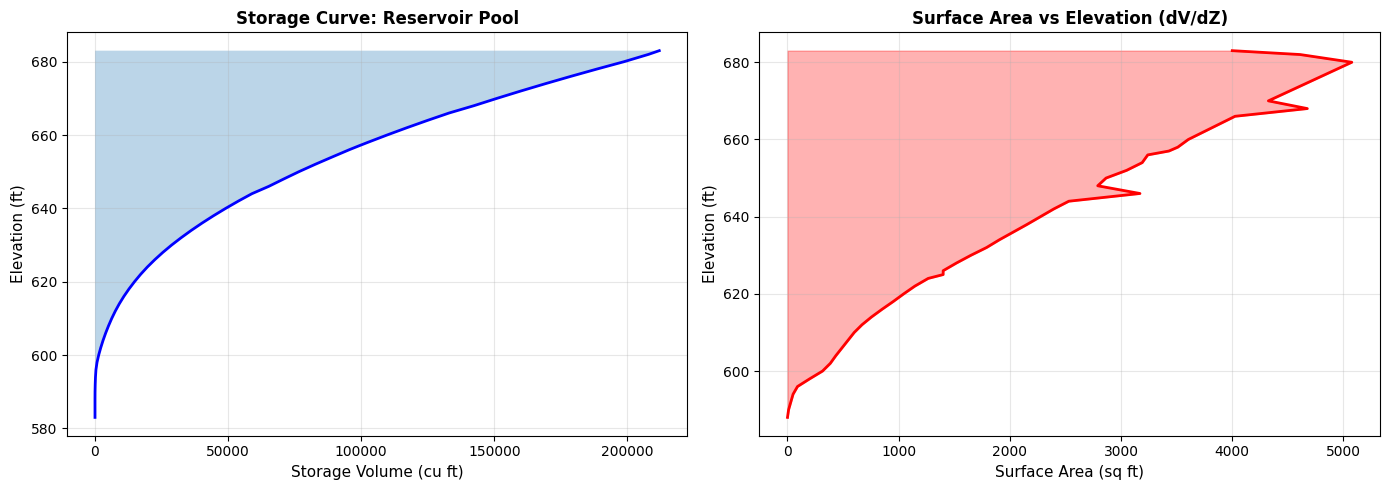


Storage Statistics:
  Total storage capacity: 212000 cu ft
  Elevation range: 100.0 ft
  Average surface area: 2213 sq ft


In [20]:
if len(storage_areas) > 0 and len(elev_vol) > 0:
    # Plot elevation-volume curve
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Plot 1: Volume vs Elevation
    ax1.plot(elev_vol['Volume'], elev_vol['Elevation'], 'b-', linewidth=2)
    ax1.fill_betweenx(elev_vol['Elevation'], 0, elev_vol['Volume'], alpha=0.3)
    ax1.set_xlabel('Storage Volume (cu ft)', fontsize=11)
    ax1.set_ylabel('Elevation (ft)', fontsize=11)
    ax1.set_title(f'Storage Curve: {area_name}', fontsize=12, fontweight='bold')
    ax1.grid(True, alpha=0.3)

    # Plot 2: Incremental Storage (dV/dZ)
    elev_vol['dV'] = elev_vol['Volume'].diff()
    elev_vol['dZ'] = elev_vol['Elevation'].diff()
    elev_vol['Surface_Area'] = elev_vol['dV'] / elev_vol['dZ']

    ax2.plot(elev_vol['Surface_Area'], elev_vol['Elevation'], 'r-', linewidth=2)
    ax2.fill_betweenx(elev_vol['Elevation'], 0, elev_vol['Surface_Area'], alpha=0.3, color='red')
    ax2.set_xlabel('Surface Area (sq ft)', fontsize=11)
    ax2.set_ylabel('Elevation (ft)', fontsize=11)
    ax2.set_title('Surface Area vs Elevation (dV/dZ)', fontsize=12, fontweight='bold')
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    print("\nStorage Statistics:")
    print(f"  Total storage capacity: {elev_vol['Volume'].max():.0f} cu ft")
    print(f"  Elevation range: {elev_vol['Elevation'].max() - elev_vol['Elevation'].min():.1f} ft")
    print(f"  Average surface area: {elev_vol['Surface_Area'].mean():.0f} sq ft")
else:
    print("Skipping storage visualization - no storage area data available")
    print("Note: This geometry may use 2D flow areas instead of traditional storage areas.")

## Section 2: SA/2D Connection Operations

Connections link storage areas to 2D flow areas for dam breach analysis. We'll extract connection properties and dam crest profiles from BaldEagleCrkMulti2D, and pull gate information from the Davis project.


### 2.1 List All Connections

In [21]:
# Extract all connections (Bald Eagle geometry)
bald_eagle_connections = RasGeometry.get_connections(dam_geom_file)

print(f"SA/2D Connections found (Bald Eagle): {len(bald_eagle_connections)}")

if len(bald_eagle_connections) > 0:
    print("")
    print("Connection inventory:")
    display.display(bald_eagle_connections[['Connection_Name', 'Upstream_Area', 'Downstream_Area',
                                            'Weir_Width', 'Weir_Coefficient', 'SE_Count', 'Num_Gates']])

    print("")
    print("Connection summary:")
    print(f"  Total weir width: {bald_eagle_connections['Weir_Width'].sum():.1f} ft")
    print(f"  Total gates: {bald_eagle_connections['Num_Gates'].sum():.0f}")
    print(
        "  Weir coefficient range: "
        f"{bald_eagle_connections['Weir_Coefficient'].min():.2f} "
        f"to {bald_eagle_connections['Weir_Coefficient'].max():.2f}"
    )
else:
    print("No connections found in this geometry file")


2026-01-12 12:51:11 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g12


SA/2D Connections found (Bald Eagle): 0
No connections found in this geometry file


### 2.2 Extract Dam Crest Profile

In [22]:
if len(bald_eagle_connections) > 0:
    # Get weir profile for first connection
    conn_name = bald_eagle_connections.iloc[0]['Connection_Name']

    print(f"Extracting weir profile for connection: {conn_name}")
    print(f"  Upstream: {bald_eagle_connections.iloc[0]['Upstream_Area']}")
    print(f"  Downstream: {bald_eagle_connections.iloc[0]['Downstream_Area']}")

    weir_profile = RasGeometry.get_connection_weir_profile(dam_geom_file, conn_name)

    print("")
    print("Weir/Dam Crest Profile:")
    print(f"  Points: {len(weir_profile)}")
    print(f"  Station range: {weir_profile['Station'].min():.1f} to {weir_profile['Station'].max():.1f} ft")
    print(f"  Elevation range: {weir_profile['Elevation'].min():.2f} to {weir_profile['Elevation'].max():.2f} ft")
    print(f"  Crest length: {weir_profile['Station'].max() - weir_profile['Station'].min():.1f} ft")

    print("")
    print("First 10 points:")
    display.display(weir_profile.head(10))
else:
    print("Skipping weir profile extraction - no connections found")


Skipping weir profile extraction - no connections found


### 2.3 Visualize Dam Crest Profile

In [23]:
if len(bald_eagle_connections) > 0:
    # Plot weir/dam crest profile
    fig, ax = plt.subplots(figsize=(12, 6))

    ax.plot(weir_profile['Station'], weir_profile['Elevation'],
            'ro-', linewidth=2, markersize=6, label='Dam Crest')
    ax.fill_between(weir_profile['Station'], weir_profile['Elevation'],
                     weir_profile['Elevation'].min() - 10,
                     alpha=0.3, color='brown')

    ax.set_xlabel('Station Along Dam (ft)', fontsize=12)
    ax.set_ylabel('Crest Elevation (ft)', fontsize=12)
    ax.set_title(f'Dam Crest Profile: {conn_name}',
                 fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=10)

    # Add statistics
    stats_text = "\n".join([
        f'Points: {len(weir_profile)}',
        f'Length: {weir_profile["Station"].max() - weir_profile["Station"].min():.1f} ft',
        f'Elev Range: {weir_profile["Elevation"].min():.1f} - {weir_profile["Elevation"].max():.1f} ft',
        f'Weir Coef: {bald_eagle_connections.iloc[0]["Weir_Coefficient"]:.2f}'
    ])
    ax.text(0.02, 0.98, stats_text,
            transform=ax.transAxes,
            verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
            fontsize=10)

    plt.tight_layout()
    plt.show()
else:
    print("Skipping visualization - no connections")


Skipping visualization - no connections


### 2.4 Extract Gate Information

Gate information is pulled from the Davis project (which includes gate definitions).


In [24]:
if davis_gate_geom_file is not None and len(davis_gate_connections) > 0:
    # Get gates for first connection with gates (Davis)
    conn_name_with_gates = davis_gate_connections.iloc[0]['Connection_Name']

    print(f"Extracting gates for Davis connection: {conn_name_with_gates}")
    print(f"  Geometry file: {davis_gate_geom_file.name}")

    gates = RasGeometry.get_connection_gates(
        davis_gate_geom_file,
        conn_name_with_gates
    )

    print("")
    print(f"Gates found: {len(gates)}")

    if len(gates) > 0:
        print("")
        print("Gate parameters:")
        display.display(gates[['Gate_Name', 'Width', 'Height', 'Invert', 'Gate_Coefficient']])

        # Visualize gate geometry
        fig, ax = plt.subplots(figsize=(8, 6))

        for idx, gate in gates.iterrows():
            # Draw gate as rectangle
            width = gate['Width']
            height = gate['Height']
            invert = gate['Invert']

            rect = plt.Rectangle((idx * 20, invert), width, height,
                                  linewidth=2, edgecolor='blue',
                                  facecolor='lightblue', alpha=0.5)
            ax.add_patch(rect)

            # Label gate
            ax.text(idx * 20 + width/2, invert + height + 2,
                    gate['Gate_Name'],
                    ha='center', fontsize=10, fontweight='bold')
            ax.text(idx * 20 + width/2, invert + height/2,
                    f"{width}' x {height}'\nInvert: {invert}'",
                    ha='center', va='center', fontsize=9)

        ax.set_xlim(-5, len(gates) * 20 + 15)
        ax.set_ylim(invert - 10, invert + height + 20)
        ax.set_xlabel('Position', fontsize=11)
        ax.set_ylabel('Elevation (ft)', fontsize=11)
        ax.set_title(f'Gate Configuration: {conn_name_with_gates}',
                     fontsize=12, fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.set_aspect('equal')
        plt.tight_layout()
        plt.show()
else:
    print("No gates found in the Davis project connections")


No gates found in the Davis project connections


### 2.5 Analyze All Connections

Analyze all Davis connections to summarize weir profiles and gate settings.


In [25]:
if davis_gate_geom_file is not None and len(davis_connections) > 0:
    # Extract profiles for all connections (Davis)
    print("Processing all connections (Davis)...")

    for idx, conn in davis_connections.iterrows():
        conn_name = conn['Connection_Name']

        try:
            # Get weir profile
            profile = RasGeometry.get_connection_weir_profile(
                davis_gate_geom_file,
                conn_name
            )

            # Get gates
            gates = RasGeometry.get_connection_gates(
                davis_gate_geom_file,
                conn_name
            )

            print(f"{idx+1}. {conn_name}:")
            print(f"   {conn['Upstream_Area']} -> {conn['Downstream_Area']}")
            print(
                f"   Weir profile: {len(profile)} points, "
                f"length={profile['Station'].max():.0f} ft"
            )
            print(f"   Gates: {len(gates)}")
            if len(gates) > 0:
                gate = gates.iloc[0]
                print(
                    f"     {gate['Gate_Name']}: {gate['Width']:.0f}' W x "
                    f"{gate['Height']:.0f}' H, Invert={gate['Invert']:.0f}'"
                )
            print()

        except Exception as e:
            print(f"{idx+1}. {conn_name}: ERROR - {e}")
else:
    print("No Davis connections to process")


No Davis connections to process


## Section 3: Practical Application - Dam Breach Analysis Workflow

Real-world workflow combining storage areas, connections, and gate operations for dam breach analysis. Storage and connection geometry come from BaldEagleCrkMulti2D; gate inventory is illustrated with the Davis project.


In [26]:
print("="*70)
print("DAM BREACH ANALYSIS WORKFLOW")
print("="*70)

# Step 1: Identify storage areas (Bald Eagle)
print("")
print("Step 1: Storage Areas")
storage_areas = RasGeometry.get_storage_areas(dam_geom_file)
print(f"  Found {len(storage_areas)} storage area(s)")
for area in storage_areas:
    print(f"    - {area}")

# Step 2: Get storage capacity (Bald Eagle)
if len(storage_areas) > 0:
    print("")
    print("Step 2: Storage Capacity")
    elev_vol = RasGeometry.get_storage_elevation_volume(dam_geom_file, storage_areas[0])
    print(f"  Maximum storage: {elev_vol['Volume'].max():.0f} cu ft")
    print(f"  Pool elevation range: {elev_vol['Elevation'].min():.1f} to {elev_vol['Elevation'].max():.1f} ft")

# Step 3: Identify connections (Bald Eagle)
print("")
print("Step 3: Connections")
bald_eagle_connections = RasGeometry.get_connections(dam_geom_file)
print(f"  Found {len(bald_eagle_connections)} connection(s)")
for _, conn in bald_eagle_connections.iterrows():
    print(f"    - {conn['Connection_Name']}: {conn['Upstream_Area']} -> {conn['Downstream_Area']}")

# Step 4: Analyze dam crest (Bald Eagle)
if len(bald_eagle_connections) > 0:
    dam_connections = bald_eagle_connections[
        bald_eagle_connections['Connection_Name'].str.contains('Dam', case=False, na=False)
    ]

    if len(dam_connections) > 0:
        print("")
        print("Step 4: Dam Crest Geometry")
        dam_name = dam_connections.iloc[0]['Connection_Name']
        dam_profile = RasGeometry.get_connection_weir_profile(dam_geom_file, dam_name)

        print(f"  Dam: {dam_name}")
        print(f"  Crest length: {dam_profile['Station'].max() - dam_profile['Station'].min():.0f} ft")
        print(f"  Crest elevation range: {dam_profile['Elevation'].min():.1f} to {dam_profile['Elevation'].max():.1f} ft")
        print(f"  Min crest elevation: {dam_profile['Elevation'].min():.1f} ft")

# Step 5: Gate inventory (Davis)
print("")
print("Step 5: Gate Inventory (Davis)")
if (
    davis_gate_geom_file is not None
    and len(davis_connections) > 0
    and "Num_Gates" in davis_connections.columns
):
    total_gates = davis_connections['Num_Gates'].sum()
    print(f"  Total gates in Davis geometry: {total_gates:.0f}")

    if total_gates > 0:
        conn_with_gates = davis_connections[davis_connections['Num_Gates'] > 0]
        for _, conn in conn_with_gates.iterrows():
            gates = RasGeometry.get_connection_gates(
                davis_gate_geom_file,
                conn['Connection_Name']
            )
            print(f"  {conn['Connection_Name']}: {len(gates)} gate(s)")
            for _, gate in gates.iterrows():
                print(
                    f"    - {gate['Gate_Name']}: {gate['Width']:.0f}' x "
                    f"{gate['Height']:.0f}', Invert {gate['Invert']:.0f}'"
                )
else:
    print("  No gate connections found in Davis project")

print("")
print("="*70)
print("ANALYSIS COMPLETE")
print("="*70)


2026-01-12 12:51:11 - ras_commander.geom.GeomStorage - INFO - Found 1 storage areas in BaldEagleDamBrk.g12
2026-01-12 12:51:11 - ras_commander.geom.GeomStorage - INFO - Extracted 52 elevation-volume points for Reservoir Pool
2026-01-12 12:51:11 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g12


DAM BREACH ANALYSIS WORKFLOW

Step 1: Storage Areas
  Found 1 storage area(s)
    - Reservoir Pool

Step 2: Storage Capacity
  Maximum storage: 212000 cu ft
  Pool elevation range: 583.0 to 683.0 ft

Step 3: Connections
  Found 0 connection(s)

Step 5: Gate Inventory (Davis)
  No gate connections found in Davis project

ANALYSIS COMPLETE


## Summary

### Methods Demonstrated

**Storage Area Operations (RasGeometry)**:
- `get_storage_areas()` - List storage areas with metadata
- `get_storage_elevation_volume()` - Extract elevation-volume relationships

**SA/2D Connection Operations (RasGeometry)**:
- `get_connections()` - List SA/2D connections
- `get_connection_weir_profile()` - Extract dam crest profiles
- `get_connection_gates()` - Extract gate definitions (Davis project)

**Multi-Project Context**:
- `RasPrj` + `init_ras_project(..., ras_object=...)` to keep project data isolated
